# Clustering to identify user personas

### Use case can be group users into investment personas (e.g. “Conservative Saver”, “Aggressive Trader”, “Balanced Investor”)
### models: k-means clustering, PCA

## Clustering

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Load Data ---
df = pd.read_excel("data/portfolio_data.xlsx")

# --- Select Meaningful Features ---
features = [
    'purchase_price', 'quantity', 'sale_price', 
    'profit', 'total_profit', 
    'risk_level_number', 'holding_duration', 'return_percentage'
]
df_selected = df[features].dropna()

# --- Clip Extreme Outliers on Return Percentage ---
df_selected['return_percentage'] = df_selected['return_percentage'].clip(lower=0, upper=5000)

# --- Scale the Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# --- Dimensionality Reduction (PCA) to 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# --- Add Clusters to DataFrame ---
df_selected['cluster'] = clusters




In [27]:
df.head(5)

,portfolio_id,investment_type,purchase_date,purchase_price,quantity,sale_date,sale_price,profit,total_profit,risk_level,risk_level_number,holding_duration,return_percentage
0,1,T-Bills,2011-06-25,109.18,465,2018-01-28,450.17,340.99,158560.35,Low,2.62,2409,312.32
1,2,T-Bills,2012-11-08,519.70,3461,2020-04-14,442.58,-77.12,-266912.32,Low,2.48,2714,-14.84
2,3,Options,2008-07-05,612.78,775,2020-07-21,895.64,282.86,219216.50,Very High,8.58,4399,46.16
3,4,ETFs,2011-11-17,9.04,4043,2021-11-30,463.98,454.94,1839322.42,Moderate,5.41,3666,5032.52
4,5,Derivatives,2013-09-24,498.19,4042,2016-10-22,112.98,-385.21,-1557018.82,High,6.35,1124,-77.32


#### Plot

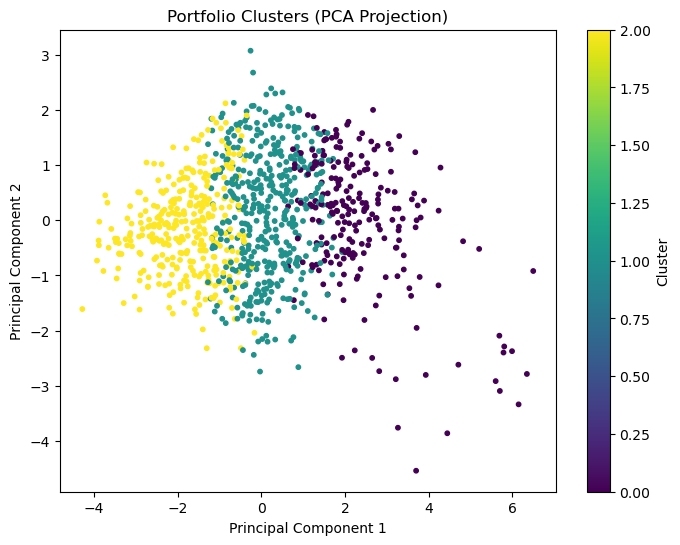

In [28]:
# --- Plot the Clusters in PCA Space ---
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('Portfolio Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show(block=True)

## Profiling


=== Cluster Profiles ===
         purchase_price     quantity  sale_price      profit  total_profit  \
cluster                                                                      
0            236.153661  6237.026786  747.475000  511.321339  3.002247e+06   
1            453.425500  3291.106818  528.755955   75.330455  2.294160e+05   
2            719.930030  5808.857143  300.105327 -419.824702 -2.147658e+06   

         risk_level_number  holding_duration  return_percentage  
cluster                                                          
0                 5.610625       4009.616071         687.445625  
1                 5.685523       4228.720455          64.977045  
2                 5.755119       4151.139881           0.000000  


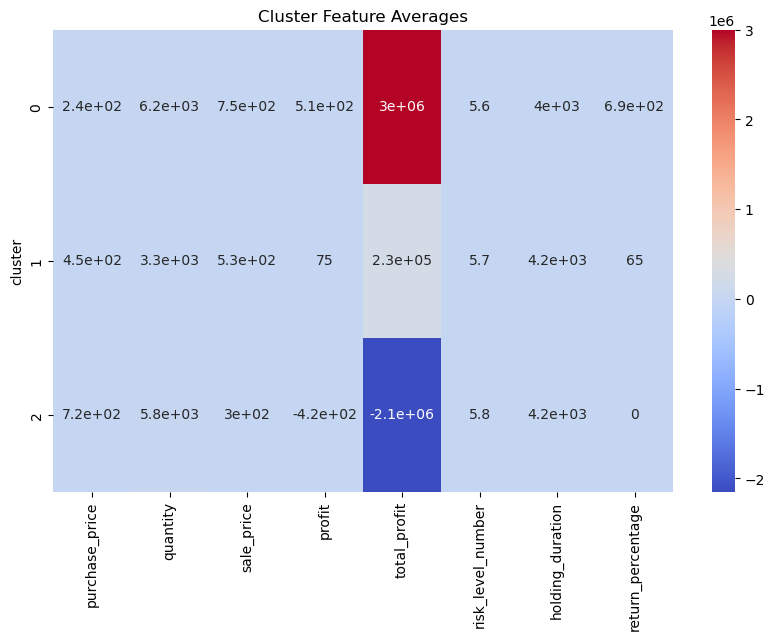

In [29]:
# Step 1: Cluster profiles
cluster_profiles = df_selected.groupby('cluster').mean()

# Step 2: Display nicely
print("\n=== Cluster Profiles ===")
print(cluster_profiles)

# Optional: visualize cluster profiles (optional but cool)
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(cluster_profiles, annot=True, cmap="coolwarm")
plt.title("Cluster Feature Averages")
plt.show()


### Mapping clusters / identifying personas

In [30]:
# Correct cluster-to-persona mapping based on the real cluster statistics
persona_mapping = {
    0: "Aggressive Profitable Investors",  # Cluster 0: big gains
    1: "Steady Balanced Investors",        # Cluster 1: moderate gains
    2: "Unsuccessful Risk Takers"           # Cluster 2: losses
}

# Apply the corrected persona names
df_selected['persona'] = df_selected['cluster'].map(persona_mapping)

# View sample
print(df_selected[['cluster', 'persona']].head())


   cluster                          persona
0        1        Steady Balanced Investors
1        1        Steady Balanced Investors
2        1        Steady Balanced Investors
3        0  Aggressive Profitable Investors
4        2         Unsuccessful Risk Takers


### Visualize plot with personas

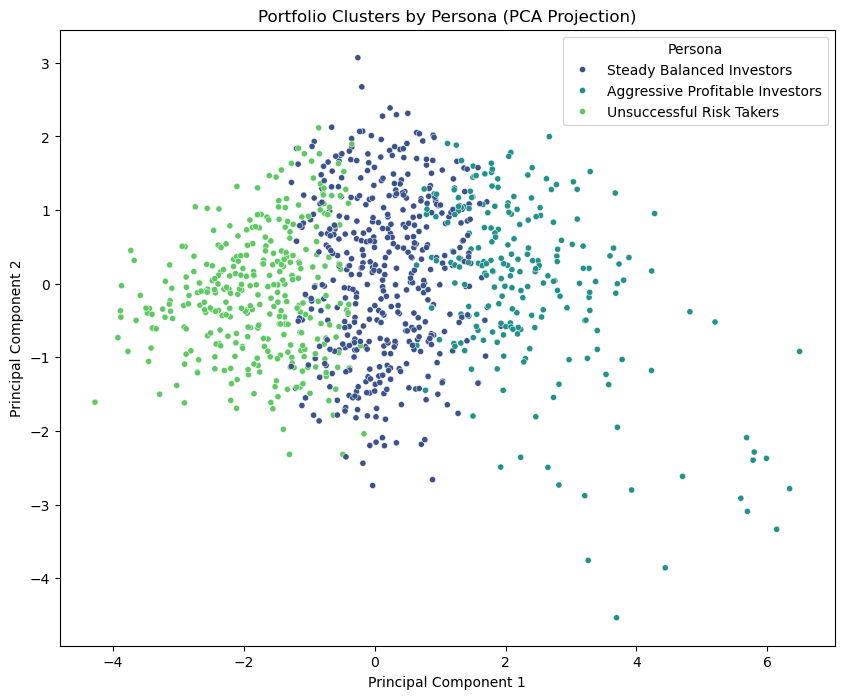

In [31]:
import seaborn as sns

# Plot the PCA projection with personas as color
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_selected['persona'], palette="viridis", s=20)
plt.title('Portfolio Clusters by Persona (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Persona', loc='best')
plt.show()


### Input portfolio row to retrieve the persona it belongs too

In [32]:
# --- Example: Manually input a new portfolio ---
new_portfolio = {
    'purchase_price': 500,
    'quantity': 2000,
    'sale_price': 700,
    'profit': 200,
    'total_profit': 400000,
    'risk_level_number': 5,
    'holding_duration': 4000,
    'return_percentage': 40  # NOTE: Input real percentage, will be clipped if needed
}

# --- Turn it into a DataFrame ---
new_df = pd.DataFrame([new_portfolio])

# --- Clip return percentage if necessary ---
new_df['return_percentage'] = new_df['return_percentage'].clip(lower=0, upper=5000)

# --- Use the same scaler ---
new_scaled = scaler.transform(new_df)

# --- Predict cluster ---
predicted_cluster = kmeans.predict(new_scaled)[0]

# --- Map to persona ---
predicted_persona = persona_mapping[predicted_cluster]

# --- Output ---
print(f"\nPredicted Persona: {predicted_persona}")



Predicted Persona: Steady Balanced Investors
